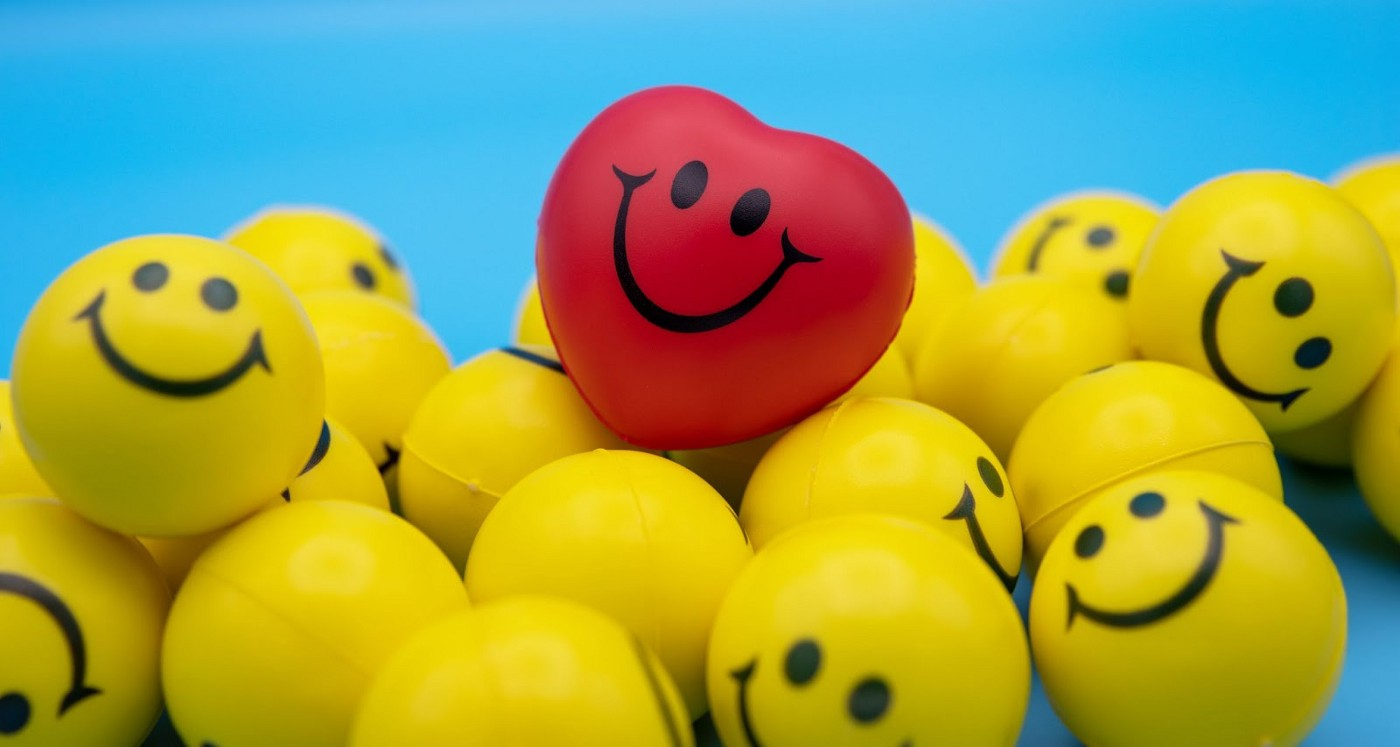

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Description
    </p>
</div>


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 14px; font-weight: bold;">
       Dive into the vibrant world of emotions with this Twitter dataset! Each entry unfolds a snippet of a Twitter message, encapsulating the essence of human sentiments. The emotions are artfully categorized into six distinctive hues: Sadness (0), Joy (1), Love (2), Anger (3), Fear (4), and Surprise (5). Whether you're unraveling the threads of sentiment, exploring the depths of emotion classification, or delving into the treasures of text mining, this dataset offers a captivating journey through the nuanced landscape of emotions in the realm of social media.
    </p>
</div>


> Columns:
> 
>  * text: A string feature representing the content of the Twitter message.
>  * label: A classification label indicating the primary emotion, with values ranging from 0 to 5.

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        1. Import Libraries
    </p>
</div>


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

import warnings
warnings.filterwarnings ('ignore')

2024-02-26 06:14:30.725309: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 06:14:30.725521: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 06:14:30.936563: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        2. Import Data
    </p>
</div>


In [2]:
df = pd.read_csv("/kaggle/input/emotions/text.csv")


In [3]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [4]:
df = df.drop(columns=['Unnamed: 0'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416809 entries, 0 to 416808
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    416809 non-null  object
 1   label   416809 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.4+ MB


In [6]:
def null_count():
    return pd.DataFrame({'features': df.columns,
                'dtypes': df.dtypes.values,
                'NaN count': df.isnull().sum().values,
                'NaN percentage': df.isnull().sum().values/df.shape[0]}).style.background_gradient(cmap='turbo',low=0.1,high=0.01)
null_count()

,features,dtypes,NaN count,NaN percentage
0,text,object,0,0.000000
1,label,int64,0,0.000000


In [7]:
df.duplicated().sum()

686

In [8]:
df = df.drop_duplicates()

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        3.Feature Enginering
    </p>
</div>


In [9]:
df1 =df.copy()

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        Text
    </p>
</div>


In [10]:
unique_review = df1['text'].unique()
unique_review

array(['i just feel really helpless and heavy hearted',
       'ive enjoyed being able to slouch about relax and unwind and frankly needed it after those last few weeks around the end of uni and the expo i have lately started to find myself feeling a bit listless which is never really a good thing',
       'i gave up my internship with the dmrg and am feeling distraught',
       ...,
       'i feel very curious be why previous early dawn in the time here don t you seek his trouble',
       'i feel that becuase of the tyranical nature of the government in el salvador and the savage social conditions of the general people that the set of thought to run the shoe shop in miguel marmols testimoney was able to work',
       'i think that after i had spent some time investigating the surroundings and things i started to feel more curious about other people'],
      dtype=object)

In [11]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'www\.\S+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    tokens = word_tokenize(text)
    # Remove stopwords and stem tokens
    cleaned_tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(cleaned_tokens)
    return cleaned_text

# Clean the text data in the 'text' column of DataFrame df
df1['cleaned_text'] = df1['text'].apply(clean_text)

# Print the DataFrame with cleaned text data
print(df1[['text', 'cleaned_text']])

                                                     text  \
0           i just feel really helpless and heavy hearted   
1       ive enjoyed being able to slouch about relax a...   
2       i gave up my internship with the dmrg and am f...   
3                              i dont know i feel so lost   
4       i am a kindergarten teacher and i am thoroughl...   
...                                                   ...   
416804  i feel like telling these horny devils to find...   
416805  i began to realize that when i was feeling agi...   
416806  i feel very curious be why previous early dawn...   
416807  i feel that becuase of the tyranical nature of...   
416808  i think that after i had spent some time inves...   

                                             cleaned_text  
0                        feel realli helpless heavi heart  
1       ive enjoy abl slouch relax unwind frankli need...  
2                    gave internship dmrg feel distraught  
3                          

In [12]:
df1['cleaned_text'] = df1['cleaned_text'].str.replace("http", "").str.replace("href", "").str.replace("img", "").str.replace("irc", "")


In [13]:
unique_review = df1['cleaned_text'].unique()
unique_review

array(['feel realli helpless heavi heart',
       'ive enjoy abl slouch relax unwind frankli need last week around end uni expo late start find feel bit listless never realli good thing',
       'gave internship dmrg feel distraught', ...,
       'feel curiou previou earli dawn time seek troubl',
       'feel becuas tyran natur govern el salvador savag social condit gener peopl set thought run shoe shop miguel marmol testimoney abl work',
       'think spent time investig surround thing start feel curiou peopl'],
      dtype=object)

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
        Label
    </p>
</div>


In [14]:
df1.label.value_counts()

label
1    140779
0    120989
3     57235
4     47664
2     34497
5     14959
Name: count, dtype: int64

In [15]:
mapping = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

df1['Emotion'] = df1['label'].map(mapping)


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       4.EDA
    </p>
</div>


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Emotion Distribution
    </p>
</div>


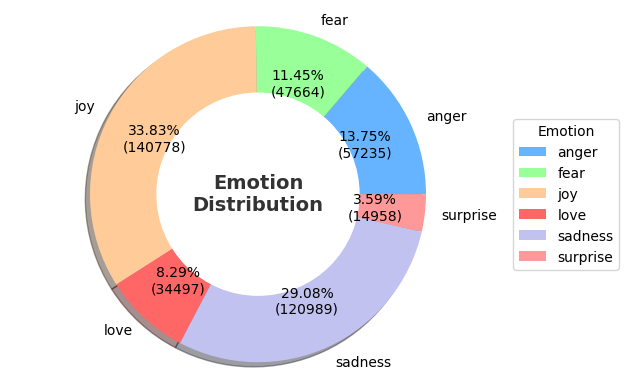

In [16]:
unique_emotion = df1['Emotion'].unique()

explode = [0] * len(unique_emotion)

emotion_counts = df1.groupby("Emotion").size()

colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff6666', '#c2c2f0', '#ff9999']  # Menambahkan warna untuk 6 kategori

fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(
    x=emotion_counts, 
    labels=emotion_counts.index,
    autopct=lambda p: f'{p:.2f}%\n({int(p*sum(emotion_counts)/100)})', 
    wedgeprops=dict(width=0.7),
    textprops=dict(size=10, color="black"),  
    pctdistance=0.7,
    colors=colors,
    explode=explode,  
    shadow=True
)

center_circle = plt.Circle((0, 0), 0.6, color='white', fc='white', linewidth=1.25)
fig.gca().add_artist(center_circle)

ax.text(0, 0, 'Emotion\nDistribution', ha='center', va='center', fontsize=14, fontweight='bold', color='#333333')

ax.legend(emotion_counts.index, title="Emotion", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

ax.axis('equal')  

plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Bigrams
    </p>
</div>


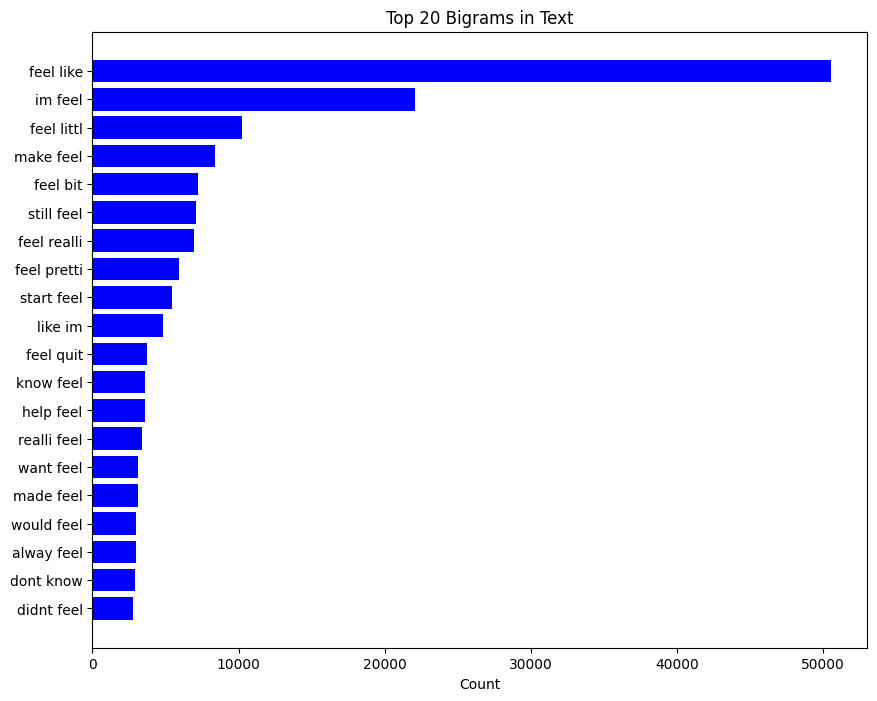

In [17]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_bigrams = get_top_n_bigram(df1['cleaned_text'], 20)

df_bigrams = pd.DataFrame(common_bigrams, columns=['bigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_bigrams['bigram'], df_bigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Bigrams in Text')
plt.gca().invert_yaxis()
plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Trigrams
    </p>
</div>


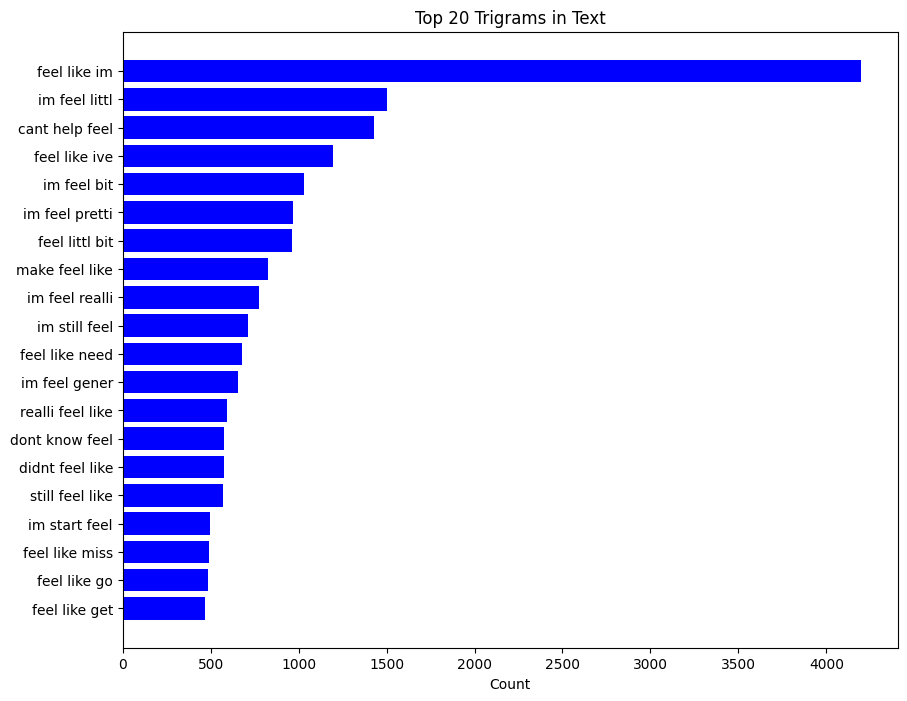

In [18]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_trigrams = get_top_n_trigram(df1['cleaned_text'], 20)

df_trigrams = pd.DataFrame(common_trigrams, columns=['trigram', 'count'])

plt.figure(figsize=(10, 8))
plt.barh(df_trigrams['trigram'], df_trigrams['count'], color='blue')
plt.xlabel('Count')
plt.title('Top 20 Trigrams in Text')
plt.gca().invert_yaxis()
plt.show()

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       WordCloud
    </p>
</div>


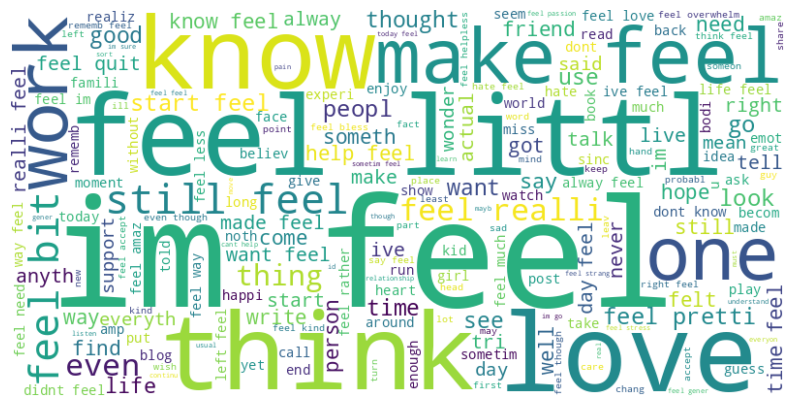

In [19]:
def make_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

all_words = ' '.join(df1['cleaned_text'])

make_word_cloud(all_words)


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       5.Modeling
    </p>
</div>


In [20]:
df2 = df1.copy()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df2['cleaned_text'], df2['label'], test_size=0.2, random_state=42)

<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       CNN
    </p>
</div>


In [22]:
tokenizer = Tokenizer(num_words=50000)
tokenizer.fit_on_texts(X_train)


In [23]:
X_train_padded = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100, padding='post')
X_test_padded = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100, padding='post')


In [24]:
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=50000, output_dim=16, input_length=100))
cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(units=64, activation='relu'))
cnn_model.add(Dense(units=6, activation='softmax'))


In [25]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [26]:
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           800000    
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           10368     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 819014 (3.12 MB)
Trainable params: 819014 (3.12 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

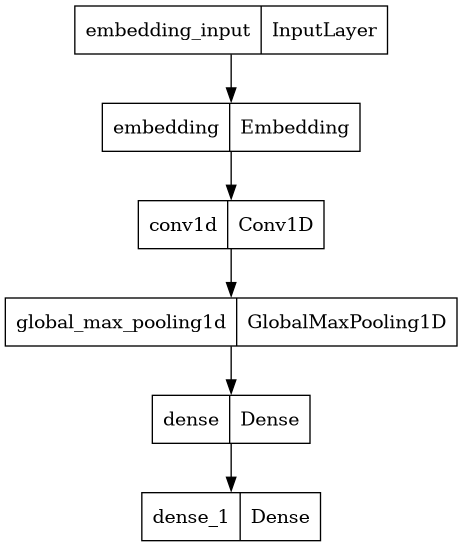

In [27]:
plot_model(cnn_model, to_file='model.png')


In [28]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=50, 
                             validation_data=(X_test_padded, y_test),
                             callbacks=[early_stopping])

Epoch 1/50
10404/10404 [==============================] - 140s 13ms/step - loss: 0.2326 - accuracy: 0.8962 - val_loss: 0.1607 - val_accuracy: 0.9171
Epoch 2/50
10404/10404 [==============================] - 141s 14ms/step - loss: 0.1496 - accuracy: 0.9218 - val_loss: 0.1545 - val_accuracy: 0.9178
Epoch 3/50
10404/10404 [==============================] - 140s 13ms/step - loss: 0.1347 - accuracy: 0.9270 - val_loss: 0.1538 - val_accuracy: 0.9184
Epoch 4/50
10404/10404 [==============================] - 142s 14ms/step - loss: 0.1238 - accuracy: 0.9306 - val_loss: 0.1567 - val_accuracy: 0.9157
Epoch 5/50
10404/10404 [==============================] - 144s 14ms/step - loss: 0.1160 - accuracy: 0.9339 - val_loss: 0.1647 - val_accuracy: 0.9168
Epoch 6/50
10404/10404 [==============================] - 141s 14ms/step - loss: 0.1102 - accuracy: 0.9359 - val_loss: 0.1715 - val_accuracy: 0.9139


In [29]:
evaluation_result = cnn_model.evaluate(X_test_padded, y_test)

print("Test Loss:", evaluation_result[0])
print("Test Accuracy:", evaluation_result[1])


2601/2601 [==============================] - 10s 4ms/step - loss: 0.1538 - accuracy: 0.9184
Test Loss: 0.15377089381217957
Test Accuracy: 0.9184499979019165


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Confusion Matrix
    </p>
</div>


2601/2601 [==============================] - 10s 4ms/step


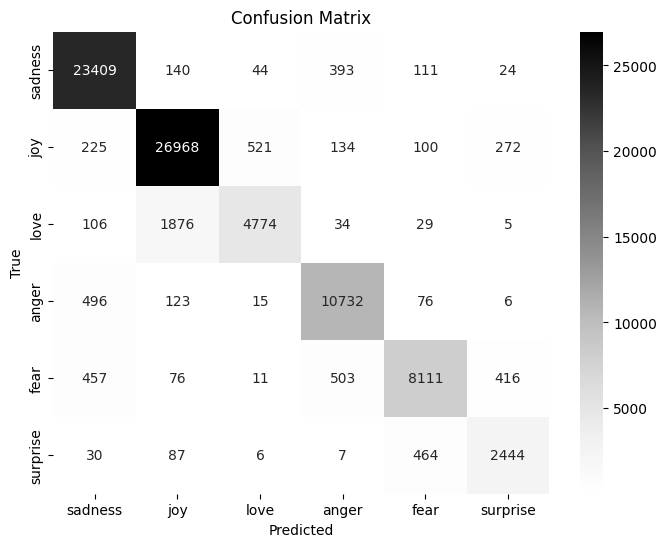

In [30]:
y_pred = np.argmax(cnn_model.predict(X_test_padded), axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Greys', 
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Classification Report
    </p>
</div>


In [31]:
target_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']  
report = classification_report(y_test, y_pred, target_names=target_names)

print(report)

              precision    recall  f1-score   support

     Sadness       0.95      0.97      0.96     24121
         Joy       0.92      0.96      0.94     28220
        Love       0.89      0.70      0.78      6824
       Anger       0.91      0.94      0.92     11448
        Fear       0.91      0.85      0.88      9574
    Surprise       0.77      0.80      0.79      3038

    accuracy                           0.92     83225
   macro avg       0.89      0.87      0.88     83225
weighted avg       0.92      0.92      0.92     83225



In [32]:
f1_scores = {'Sadness': 0.96, 'Joy': 0.94, 'Love': 0.80, 'Anger': 0.92, 'Fear': 0.88, 'Surprise': 0.81}

threshold = 0.85  

chosen_emotion = max(f1_scores, key=lambda emotion: f1_scores[emotion] if f1_scores[emotion] >= threshold else 0)

print(f"The chosen emotion is: {chosen_emotion}")


The chosen emotion is: Sadness


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Training and Validation
    </p>
</div>


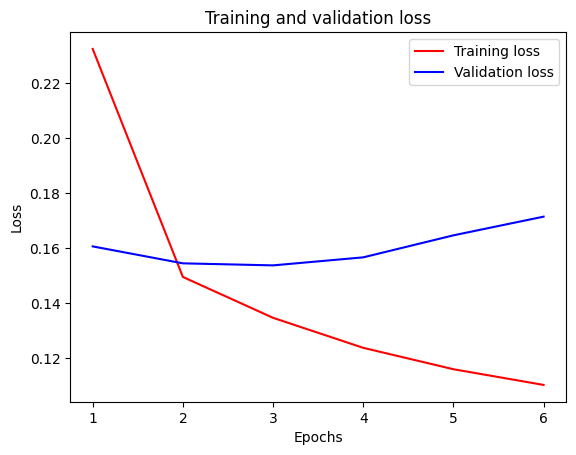

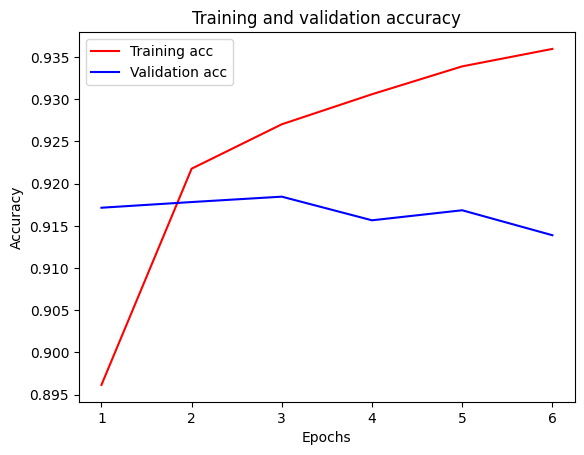

In [33]:
train_loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
train_acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       ROC Curve
    </p>
</div>


2601/2601 [==============================] - 10s 4ms/step


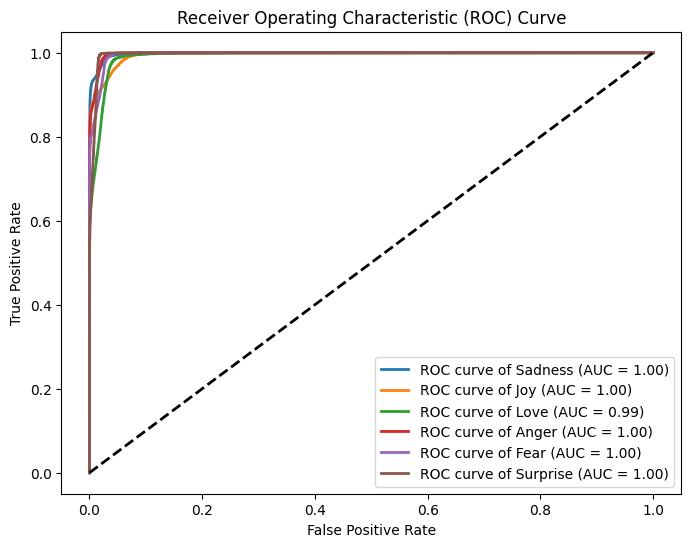

In [34]:
y_score = cnn_model.predict(X_test_padded)

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5])

fpr = dict()
tpr = dict()
roc_auc = dict()

n_classes = 6  
class_names = ['Sadness', 'Joy', 'Love', 'Anger', 'Fear', 'Surprise']

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve for each class with distinct colors
    plt.plot(fpr[i], tpr[i], lw=2,
             label='ROC curve of {0} (AUC = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


<div style="background-color: #7EC8E3; padding: 15px; border-radius: 10px; text-align: center;">
    <p style="color: #0C2E44; font-size: 18px; font-weight: bold; margin-bottom: 10px;">
        Emotion Classification Recap
    </p>
    <p style="color: #0C2E44; font-size: 16px;">
        🚀 The model soared to a stellar 92% accuracy, showcasing its prowess in astutely classifying the majority of samples.
    </p>
    <p style="color: #0C2E44; font-size: 16px;">
        😢 Delving into the realm of "Sadness," the model demonstrated a remarkable precision of 97% and a commendable recall of 94%, portraying its knack for pinpointing and categorizing instances laden with expressions of sorrow.
    </p>
    <p style="color: #0C2E44; font-size: 16px; margin-top: 10px;">
        🌟 The overall performance of the trained CNN model shines brightly, underscoring its effectiveness in the nuanced art of classifying emotions within textual data.
    </p>
</div>


<div style="background-color: skyblue; padding: 15px; border-radius: 10px;">
    <p style="color: black; font-size: 15px; font-weight: bold;">
       Finish
    </p>
</div>


<div style="background-color: #ffffff; color: #000000; padding: 10px; border-radius: 5px;">
    <p style="font-size: 16px; font-weight: bold;">
       If you discovered this notebook to be useful or enjoyable, I'd greatly appreciate any upvotes.🚀
    </p>
</div>


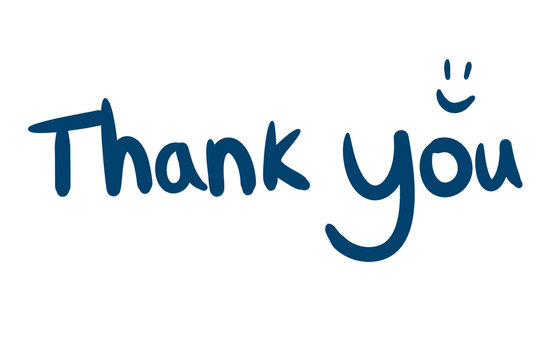